In [3]:
import os
import logging
import os

import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset
import numpy as np

In [4]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

dataDir = "/home/tako/devtools/furry-geras/coco"
dataType = "val2017"
annFile = "{}/instances_{}.json".format(dataDir, dataType)
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [5]:
size = 224
sizes = {}
for f in Path(dataDir + "/"+ dataType).glob("*.jpg"):
    
    id = int(f.name.replace(".jpg",""))
    im_ann = coco.loadImgs(id)[0]
    width = im_ann["width"]
    height = im_ann["height"]
    sizes[id] = {key: im_ann[key] for key in ["width","height"]}

In [24]:
df = pd.DataFrame().from_dict(sizes).T
df.head()

,height,width
140286,521,640
389197,426,640
50638,393,640
165500,480,640
23781,427,640


In [25]:
import seaborn as sns

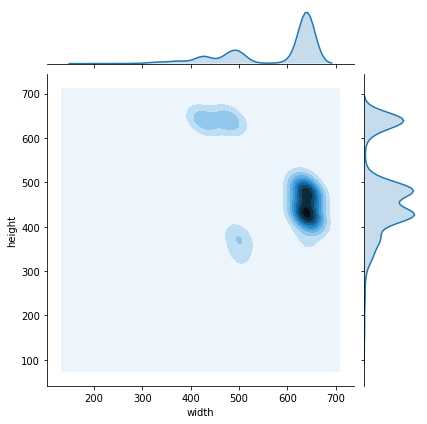

In [26]:
sns.jointplot(x="width", y="height", data=df, kind="kde")

In [21]:
from PIL import Image
size = 500
new_path = Path(dataDir + "/"+ dataType + f"-{size}")
if not new_path.exists():
    os.mkdir(new_path)

In [30]:

data_dct = {}
num_image = []
for i, f in enumerate(Path(dataDir + "/"+ dataType).glob("*.jpg")):
    id = int(f.name.replace(".jpg",""))
    im_ann = coco.loadImgs(id)[0]
    width = im_ann["width"]
    height = im_ann["height"]
    annIds = coco.getAnnIds(imgIds=id, iscrowd=False)
    objs = coco.loadAnns(annIds)
#     print(height,width)
    # sanitize bboxes
    valid_objs = []
    for obj in objs:
        x, y, w, h = obj["bbox"]
        x1 = np.max((0, x))
        y1 = np.max((0, y))
        x2 = np.min((width - 1, x1 + np.max((0, w - 1))))
        y2 = np.min((height - 1, y1 + np.max((0, h - 1))))
        if obj["area"] > 0 and x2 >= x1 and y2 >= y1:
            # obj['clean_bbox'] = [x1, y1, x2, y2]
            obj["clean_bbox"] = [x1, y1, x2 - x1, y2 - y1]
            valid_objs.append(obj)
        
    objs = valid_objs    
    bboxs = []
    for obj in objs:
        cls = obj['category_id']
        if cls != 1:
            continue   
        if obj['area'] < 2500:
            continue
        bboxs.append(obj['clean_bbox'])
    
    if len(bboxs) == 1:
        bbox = bboxs[0]
        data_dct[f.name] = {
            "filename": f,
            "y": bbox[0],
            "x": bbox[1],
            "height": bbox[2],
            "width": bbox[3],
        }
    


dataset = pd.DataFrame.from_dict(data_dct).T
dataset.to_csv(f"coco/{dataType}_one_human.csv", index=False)


In [31]:

dataset.shape

(1150, 5)

In [20]:
np.mean(a>2)

0.28

In [9]:
from fastai.vision import *

path = Path('coco')
path_hr = path/'val2017'
path_sr = path/'small-96'
path_mr = path/'medium-256'
path_lr = path/'large-400'

il = ImageItemList.from_folder(path_hr)

def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=75)

# create smaller image sets the first time this nb is run
sets = [(path_sr, 96), (path_mr, 256),(path_lr, 400)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)